In [1]:
import os, sys, time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.mode.chained_assignment = None
import h5py
import geopandas as gpd
os.sys.path.append(os.path.join(os.getcwd(),r'..\standard'))
import os, sys
sys.path.append(os.path.join(os.getcwd(),r'..\..\..'))
# import summary_helpers

%matplotlib inline

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [9]:
def load_network_summary(filepath):
    """Load network-level results using a standard procedure. """
    df = pd.read_csv(filepath)

    # Congested network components by time of day
    df.columns

    # Get freeflow from 20to5 period

    # Exclude trips taken on non-designated facilities (facility_type == 0)
    # These are artificial (weave lanes to connect HOV) or for non-auto uses 
    df = df[df['data3'] != 0]    # data3 represents facility_type

    # calculate total link VMT and VHT
    df['VMT'] = df['@tveh']*df['length']
    df['VHT'] = df['@tveh']*df['auto_time']/60

    # Define facility type
    df.loc[df['data3'].isin([1,2]), 'facility_type'] = 'highway'
    df.loc[df['data3'].isin([3,4,6]), 'facility_type'] = 'arterial'
    df.loc[df['data3'].isin([5]), 'facility_type'] = 'connector'

    # Calculate delay
    # Select links from overnight time of day
    delay_df = df.loc[df['tod'] == '20to5'][['ij','auto_time']]
    delay_df.rename(columns={'auto_time':'freeflow_time'}, inplace=True)

    # Merge delay field back onto network link df
    df = pd.merge(df, delay_df, on='ij', how='left')

    # Calcualte hourly delay
    df['total_delay'] = ((df['auto_time']-df['freeflow_time'])*df['@tveh'])/60    # sum of (volume)*(travtime diff from freeflow)

    df['county'] =df['@countyid'].map({33: 'King',
                                      35: 'Kitsap',
                                      53: 'Pierce',
                                      61: 'Snohomish'})
    
    return df

In [2]:
CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

# Relative path between notebooks and goruped output directories
relative_path = '../../../outputs'
survey_path = '../../../inputs/base_year/survey'

In [36]:
# Intersect buffer with land use file
df_lu = pd.read_csv(r'..\..\..\inputs\scenario\landuse\parcels_urbansim.txt',
                   delim_whitespace=True)

# Select only parcels with households on them to trim down records size
df_lu = df_lu[df_lu['HH_P'] > 0]

# Load as a geodataframe
gdf_lu = gpd.GeoDataFrame(
    df_lu, geometry=gpd.points_from_xy(df_lu.XCOORD_P, df_lu.YCOORD_P))

crs = {'init' : 'EPSG:2285'}
gdf_lu.crs = crs

# Buffer the parcels at one mile
buffer_dist = 5280
gdf_lu['geometry'] = gdf_lu.buffer(buffer_dist)

In [37]:
# Intersect this geography  with the network shapefile
gdf_network = gpd.read_file(r'..\..\..\inputs\scenario\networks\shapefiles\AM\AM_edges.shp')
# Do not include connectors since these are abstracted ul3==5; also remove weave links ul3==0 
gdf_network = gdf_network[~gdf_network.ul3.isin([0,5])]

In [38]:
# Select only links with a bike lane
# Get that from the network?
df = load_network_summary(os.path.join(relative_path,'network',r'network_results.csv'))

In [39]:
df = df[df['@bkfac'].isin([1,2,8,9,10])]
# bike_facility_crosswalk = {'@bkfac': {0:'none',    # No bike lane
#                                       1:'standard',    # Striped bike lane  
#                                       2:'premium',     # Protected bike lane
#                                       3:'none',    # Paved/striped shoulder
#                                       4:'none',    # Marked shared lane
#                                       5:'none',    # Bike provision undefined
#                                       6:'none',    # Defined bike route no provisions
#                                       8:'premium',    # Shared use path
#                                       9:'standard',    # Buffered bike lane (minimally coded as of 2018 BY)
#                                       10:'standard'    # neighborhood greenway (minimally coded as of 2018 BY)

In [40]:
# Only select gdf links that are in df
gdf_network = gdf_network[gdf_network['id'].isin(df['ij'])]

# Bike Network
Facilities include striped bike lane, protected bike lane, shared use path, buffered bike lane, and neighborhood greenway.

These links only represent minor arterial classification and above; local streets and any bike facilities on them are not generally included in the model network.

<AxesSubplot:>

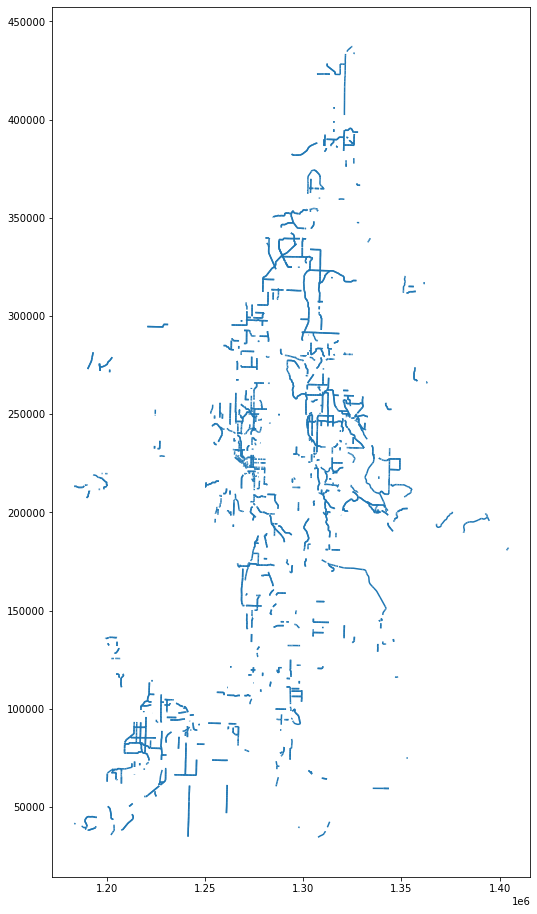

In [41]:
gdf_network.plot(figsize=(16,16))

In [42]:
gdf_intersect = gpd.overlay(gdf_network, gdf_lu, how="intersection", keep_geom_type=False)

# Will need to relaculate the lengths since some were split across the regional geographies
gdf_intersect['new_length'] = gdf_intersect.geometry.length/5280.0

# filter out the polygon results and only keep lines
gdf_intersect = gdf_intersect[gdf_intersect.geometry.type.isin(['MultiLineString','LineString'])]

In [1]:

# gdf_intersect.plot(figsize=(20,20))

In [52]:
# gdf_intersect.groupby(['PARCELID','']).sum()[['new_length']]

In [65]:
df = gdf_intersect[['length','new_length','HH_P','PARCELID','type','bkfac','id']]

In [51]:
# from input_configuration import base_year
import toml
config = toml.load(os.path.join(os.getcwd(),r'../../../configuration/input_configuration.toml'))
parcel_geog = pd.read_sql_table('parcel_'+config['base_year']+'_geography', 'sqlite:///../../../inputs/db/soundcast_inputs.db')

In [66]:
df = df.merge(parcel_geog, left_on='PARCELID', right_on='ParcelID', how='left')

In [67]:
# df.groupby('CountyName').sum()[['new_length']]
# Calcualte a population weighted total length
df['wt_length'] = df['new_length']*df['HH_P']

In [ ]:
# Average miles of bike lanes within a mile?

In [107]:
# Percent of Households with some bike lane within a mile

df = gdf_intersect[['length','new_length','HH_P','PARCELID','type','bkfac','id']]

# df = df[df['@bkfac'].isin([1,2,8,9,10])]
# bike_facility_crosswalk = {'@bkfac': {0:'none',    # No bike lane
#                                       1:'standard',    # Striped bike lane  
#                                       2:'premium',     # Protected bike lane
#                                       3:'none',    # Paved/striped shoulder
#                                       4:'none',    # Marked shared lane
#                                       5:'none',    # Bike provision undefined
#                                       6:'none',    # Defined bike route no provisions
#                                       8:'premium',    # Shared use path
#                                       9:'standard',    # Buffered bike lane (minimally coded as of 2018 BY)
#                                       10:'standard'    # neighborhood greenway (minimally coded as of 2018 BY)

bkfac_dict = {
    1: 'striped',
    2: 'protected',
    8: 'shared_use',
    9: 'buffered',
    10: 'greenway'
}

In [108]:
for bkfac in df['bkfac'].unique():
    unique_parcels = df.loc[df['bkfac'] == bkfac, 'PARCELID'].unique()
    df_lu['bike_facility_1_mile_'+str(bkfac_dict[bkfac])] = 0
    df_lu.loc[df_lu['PARCELID'].isin(unique_parcels),'bike_facility_1_mile_'+str(bkfac_dict[bkfac])] = 1

In [111]:
df = df_lu.merge(parcel_geog, left_on='PARCELID', right_on='ParcelID', how='left')

In [144]:
# Calculate household weighted average
df['region'] = 1
geog = 'region'
results_df = pd.DataFrame()
for bkfac in gdf_intersect['bkfac'].unique():
#     print('------------------------------------------')
#     print(bkfac_dict[bkfac])
    df['wt_bike_facility_1_mile_'+str(bkfac_dict[bkfac])] = df['bike_facility_1_mile_'+str(bkfac_dict[bkfac])]*df_lu['HH_P']
    results_df[bkfac_dict[bkfac]] = df.groupby(geog).sum()['wt_bike_facility_1_mile_'+str(bkfac_dict[bkfac])]/df.groupby(geog).sum()['HH_P']
    

# Percent of Households within 1 Mile of Bike Facility
Weighted average of households that have a bike facility of a certain type within 1 mile. Any segment of bike facility within a buffered mile is considered, regardless of connectivity or direct accessibility. 

In [2]:
pd.options.display.float_format = '{:0,.1%}'.format
results_df

NameError: name 'pd' is not defined

In [3]:
# Calculate household weighted average
geog = 'CountyName'
results_df = pd.DataFrame()
for bkfac in gdf_intersect['bkfac'].unique():
#     print('------------------------------------------')
#     print(bkfac_dict[bkfac])
    df['wt_bike_facility_1_mile_'+str(bkfac_dict[bkfac])] = df['bike_facility_1_mile_'+str(bkfac_dict[bkfac])]*df_lu['HH_P']
    results_df[bkfac_dict[bkfac]] = df.groupby(geog).sum()['wt_bike_facility_1_mile_'+str(bkfac_dict[bkfac])]/df.groupby(geog).sum()['HH_P']
    

NameError: name 'pd' is not defined

In [4]:
pd.options.display.float_format = '{:0,.1%}'.format
results_df

NameError: name 'pd' is not defined

In [119]:
geo_list = []
equity_geogs = ['youth','elderly','english','racial','poverty','disability']
for equity_geog in equity_geogs:
    for geog_type in ['_geog_vs_reg_total','_geog_vs_50_percent']:
        if geog_type == '_geog_vs_reg_total' or equity_geog in ['poverty','racial']:
            geo_list.append(equity_geog+geog_type)

In [137]:
results_dict = {}
for geog in geo_list:
    results_dict[geog] = {}
    for bkfac in gdf_intersect['bkfac'].unique():
    #     print('------------------------------------------')
    #     print(bkfac_dict[bkfac])
        
        df['wt_bike_facility_1_mile_'+str(bkfac_dict[bkfac])] = df['bike_facility_1_mile_'+str(bkfac_dict[bkfac])]*df_lu['HH_P']
        _df = df.groupby(geog).sum()['wt_bike_facility_1_mile_'+str(bkfac_dict[bkfac])]/df.groupby(geog).sum()['HH_P']
        
        results_dict[geog][bkfac_dict[bkfac]] = _df.loc[1]

In [140]:
pd.DataFrame(results_dict).T

,striped,protected,shared_use,buffered
youth_geog_vs_reg_total,56.8%,7.6%,19.2%,1.0%
elderly_geog_vs_reg_total,52.4%,10.8%,17.2%,0.8%
english_geog_vs_reg_total,63.0%,12.1%,17.3%,1.1%
racial_geog_vs_reg_total,59.9%,11.1%,17.5%,1.0%
racial_geog_vs_50_percent,61.5%,13.7%,15.7%,1.2%
poverty_geog_vs_reg_total,50.1%,10.0%,15.2%,1.0%
poverty_geog_vs_50_percent,37.8%,9.8%,2.5%,1.1%
disability_geog_vs_reg_total,45.2%,6.3%,14.1%,0.2%


In [141]:
results_dict = {}
for geog in geo_list:
    results_dict[geog] = {}
    for bkfac in gdf_intersect['bkfac'].unique():
    #     print('------------------------------------------')
    #     print(bkfac_dict[bkfac])
        
        df['wt_bike_facility_1_mile_'+str(bkfac_dict[bkfac])] = df['bike_facility_1_mile_'+str(bkfac_dict[bkfac])]*df_lu['HH_P']
        _df = df.groupby(geog).sum()['wt_bike_facility_1_mile_'+str(bkfac_dict[bkfac])]/df.groupby(geog).sum()['HH_P']
        
        results_dict[geog][bkfac_dict[bkfac]] = _df.loc[0]

In [142]:
_df = pd.DataFrame(results_dict).T
_df.index = ['NOT in '+i for i in _df.index]
_df

,striped,protected,shared_use,buffered
NOT in youth_geog_vs_reg_total,53.8%,15.5%,16.1%,2.9%
NOT in elderly_geog_vs_reg_total,57.8%,12.3%,18.0%,3.0%
NOT in english_geog_vs_reg_total,50.7%,11.3%,17.8%,2.5%
NOT in racial_geog_vs_reg_total,51.6%,11.9%,17.8%,2.8%
NOT in racial_geog_vs_50_percent,53.7%,11.0%,18.1%,2.2%
NOT in poverty_geog_vs_reg_total,59.0%,12.7%,19.4%,2.7%
NOT in poverty_geog_vs_50_percent,55.7%,11.6%,18.0%,2.0%
NOT in disability_geog_vs_reg_total,64.1%,16.2%,20.7%,3.5%


In [143]:
df['region'] = 1

In [ ]:
for bkfac in gdf_intersect['bkfac'].unique():
    df.groupby(geog).sum()['wt_bike_facility_1_mile_'+str(bkfac_dict[bkfac])]/df.groupby(geog).sum()['HH_P']